In [15]:
import torch
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from torchvision.transforms import transforms
import torch.nn as nn
import os
import numpy as np
from sklearn.cluster import KMeans
from tqdm import tqdm

from sklearn.decomposition import PCA

class FeatureExtractor:
    def __init__(self):
        self.net = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
        self.net = nn.Sequential(*list(self.net.children())[:-1])

        self.net.eval()

        self.transforms = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

        self.pca = PCA(n_components=64)

    def transform(self, X):
        return self.transforms(X)
    
    def fit_pca(self, X):
        self.pca.fit(X)

    def transform_pca(self, X):
        return self.pca.transform(X)

    def __call__(self, X):
        X = torch.stack(X)

        with torch.no_grad():
            features = self.net(X)

        features = torch.mean(features, axis=[2, 3])

        return features.squeeze().numpy()  # Cast to numpy array


def compute_embeddings(model, image_files, batch_size=8):
    """Compute embeddings for all images in batches using a given model and transformation."""
    embeddings = []

    # Process images in batches
    for i in tqdm(range(0, len(image_files), batch_size)):
        batch_files = image_files[i : i + batch_size]
        batch_images = [Image.open(img) for img in batch_files]

        # Apply transformation and move to device
        batch_transformed = [model.transform(img) for img in batch_images]
        
        features = model(batch_transformed)

        # Append batch embeddings to the list
        embeddings.append(features)

    return np.concatenate(embeddings)

In [16]:

# Load images from directory
image_dir = "../final_images/"
image_files = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]

net = FeatureExtractor()

# Compute embeddings for all images
embeddings = compute_embeddings(net, image_files)

net.fit_pca(embeddings)

embeddings = net.transform_pca(embeddings)

100%|██████████| 2147/2147 [04:18<00:00,  8.31it/s]


In [17]:
num_clusters = 1000
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(embeddings)
print(kmeans.inertia_)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

closest_images_to_centroid = {i: [] for i in range(num_clusters)}

# Calcular la distancia de cada imagen al centroide de su cluster y guardar las más cercanas
for i, label in enumerate(labels):
    centroid = centroids[label]
    embedding = embeddings[i]
    distance = np.linalg.norm(embedding - centroid)  # Distancia Euclidiana
    closest_images_to_centroid[label].append((i, distance))

# Ordenar las imágenes más cercanas por distancia y seleccionar las más cercanas
closest_images = {}
for cluster, images_distances in closest_images_to_centroid.items():
    images_distances.sort(key=lambda x: x[1])  # Ordenar por distancia
    closest_images[cluster] = images_distances[0]  # Tomar la imagen más cercana (la de menor distancia)

# Recuperar las imágenes más cercanas
images_indices = [idx for idx, _ in closest_images.values()]
closest_images_data = [image_files[idx] for idx in images_indices]  # 'your_images' es tu lista o array de imágenes


339303.875


In [19]:
from PIL import Image
import os

# Directorio donde se guardarán las imágenes
output_dir = 'closest_images'
os.makedirs(output_dir, exist_ok=True)

# Guardar las imágenes más cercanas a cada centroide
for cluster, (idx, _) in closest_images.items():
    img = image_files[idx]  # Obtener la imagen desde tu lista de imágenes
    img = Image.open(img)  # Convertir a formato Image desde array (si es necesario)
    img_path = os.path.join(output_dir, f'cluster_{cluster}_image_{idx}.png')
    img.save(img_path)

print(f"Imágenes guardadas en '{output_dir}'")


Imágenes guardadas en 'closest_images'


In [55]:
import numpy as np
from sklearn.metrics import pairwise_distances_argmin_min

def recommend_similar_images(model, image, embeddings, kmeans_model, num_recommendations=5):
    """
    Recomienda imágenes similares a la imagen de entrada dentro del mismo cluster.
    
    Args:
    - image: Imagen de entrada (array numpy).
    - embeddings: Matriz de embeddings (características) de todas las imágenes.
    - kmeans_model: Modelo K-means previamente entrenado.
    - num_recommendations: Número de imágenes a recomendar (por defecto, 5).
    
    Returns:
    - recommended_images: Lista de las imágenes recomendadas (arrays numpy).
    """
    image_embedding = compute_embeddings(model, [image])

    image_embedding = model.transform_pca([image_embedding])

    image_embedding = image_embedding.astype(np.float32) 

    cluster = kmeans_model.predict(image_embedding.reshape(1, -1))[0]

    cluster_indices = np.where(kmeans_model.labels_ == cluster)[0]

    distances = pairwise_distances_argmin_min(image_embedding.reshape(1, -1), embeddings[cluster_indices])[1]

    closest_indices = cluster_indices[np.argsort(distances)[:num_recommendations]]

    recommended_images = [Image.open(image_files[idx]) for idx in closest_indices]

    return recommended_images


In [64]:
import matplotlib.pyplot as plt

def show_images(input_image, recommended_images):
    """
    Muestra la imagen de entrada junto con las imágenes recomendadas.
    
    Args:
    - input_image: Imagen de entrada (array numpy).
    - recommended_images: Lista de imágenes recomendadas (arrays numpy).
    """
    num_images = len(recommended_images) + 1  # Número total de imágenes a mostrar (entrada + recomendadas)
    
    # Configurar la visualización en Matplotlib
    plt.figure(figsize=(15, 5))

    # Mostrar la imagen de entrada
    plt.subplot(1, num_images, 1)
    plt.imshow(input_image)
    plt.title('Input Image')
    plt.axis('off')

    # Mostrar las imágenes recomendadas
    for i in range(len(recommended_images)):
        plt.subplot(1, num_images, i + 2)
        plt.imshow(recommended_images[i])
        plt.title(f'Recommended {i + 1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


100%|██████████| 1/1 [00:00<00:00, 20.69it/s]


[297]
1


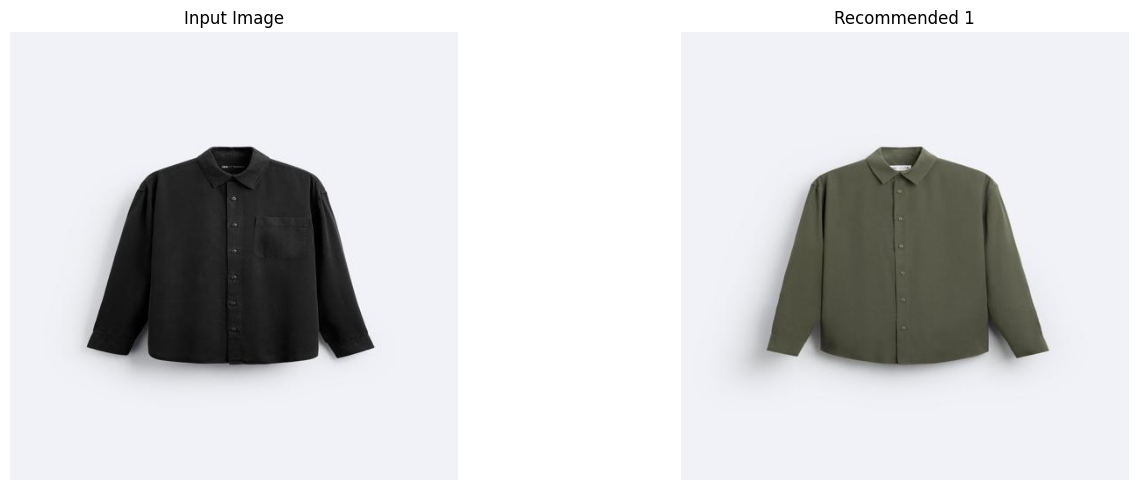

In [90]:
image_path = "../final_images/580_0.jpg"

input_image = Image.open(image_path).convert("RGB")

r = recommend_similar_images(net, image_path, embeddings, kmeans)

show_images(input_image, r)

In [62]:
input_image.show()

In [ ]:
/Users/alexdopico/HackUPC24/final_images/5208_0.jpg